In [7]:
import numpy as np
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import pyreadr
from collections import Counter
from load_data import open_charac, add_general_charac, read_memory_genes, get_memory_genes
from torch.optim import SGD
from torch.utils.data import random_split
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from binaryclass_memory import *

# Plot the logistic regression boundary

In [3]:
#Load data
fused, charac_matrix, norm_matrix, families_matrix, names_val, names_fused, data_to_fuse, val, outliers = load_all_data()

#Train model
lamb = 1000

X = np.array(fused[['CV2ofmeans_residuals','mean_expression']])
Y = np.array(fused['memory_gene'])

clf = LogisticRegression(C = lamb, class_weight = 'balanced', max_iter=10000).fit(X,Y)

# Retrieve the model parameters.
b = clf.intercept_[0]
w1, w2 = clf.coef_.T
# Calculate the intercept and gradient of the decision boundary.
c = -b/w2
m = -w1/w2

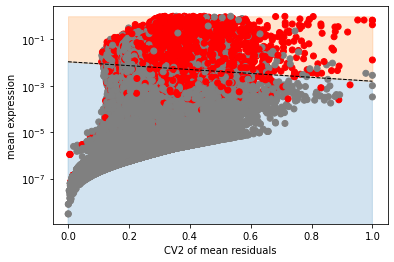

In [3]:
# Plot the data and the classification with the decision boundary.
xmin, xmax = 0, 1
ymin, ymax = 0, 1
xd = np.array([xmin, xmax])
yd = m*xd + c
plt.plot(xd, yd, 'k', lw=1, ls='--')
plt.fill_between(xd, yd, ymin, color='tab:blue', alpha=0.2)
plt.fill_between(xd, yd, ymax, color='tab:orange', alpha=0.2)

colors = ['grey','red']
plt.scatter(fused['CV2ofmeans_residuals'], fused['mean_expression'], marker='o', c= fused['memory_gene'], cmap=matplotlib.colors.ListedColormap(colors))
#plt.xlim(xmin, xmax)
#plt.ylim(ymin, ymax)
plt.ylabel('mean expression')
plt.xlabel('CV2 of mean residuals')
plt.yscale('log')
plt.show()

In [4]:
#Get traning balanced accuracy
y_pred = clf.predict(X); balanced_accuracy_score(Y, y_pred)

0.6609532961685096

# Plot SVM decision boundary

In [7]:
#Load data
fused, charac_matrix, norm_matrix, families_matrix, names_val, names_fused, data_to_fuse, val, outliers = load_all_data()

#Train model
params = {  'C': 100000, 'gamma' : 'scale'}

X = np.array(fused[['CV2ofmeans_residuals','mean_expression']])
Y = np.array(fused['memory_gene'])

clf = SVC(C=params['C'], kernel = 'rbf', gamma = params['gamma'], class_weight = 'balanced').fit(X,Y)

In [17]:
disp = sklearn.inspection.DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        response_method="predict",
        cmap=plt.cm.coolwarm,
        alpha=0.8,
        ax=ax,
        xlabel=iris.feature_names[0],
        ylabel=iris.feature_names[1],
)

# Plot the data and the classification with the decision boundary.
xmin, xmax = 0, 1
ymin, ymax = 0, 1
plt.fill_between(x_points, y_points, ymin, color='tab:blue', alpha=0.2)
plt.fill_between(x_points, y_points, ymax, color='tab:orange', alpha=0.2)

colors = ['grey','red']
plt.scatter(fused['CV2ofmeans_residuals'], fused['mean_expression'], marker='o', c= fused['memory_gene'], cmap=matplotlib.colors.ListedColormap(colors))
#plt.xlim(xmin, xmax)
#plt.ylim(ymin, ymax)
plt.ylabel('mean expression')
plt.xlabel('CV2 of mean residuals')
plt.yscale('log')
plt.show()

AttributeError: module 'sklearn.inspection' has no attribute 'DecisionBoundaryDisplay'

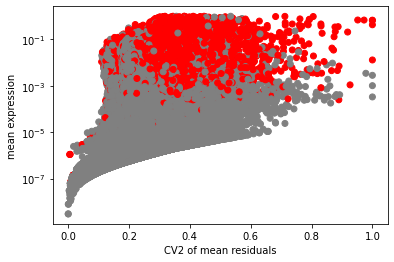

In [4]:
h = .0002  # step size in the mesh

'''# create a mesh to plot in
x_min, x_max = 0, 1
y_min, y_max = 0, 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)'''

colors = ['grey','red']
plt.scatter(fused['CV2ofmeans_residuals'], fused['mean_expression'], marker='o', c= fused['memory_gene'], cmap=matplotlib.colors.ListedColormap(colors))
#plt.xlim(xmin, xmax)
#plt.ylim(ymin, ymax)
plt.ylabel('mean expression')
plt.xlabel('CV2 of mean residuals')
plt.yscale('log')
plt.show()

plt.show()

In [18]:
#Get traning balanced accuracy
y_pred = clf.predict(X); balanced_accuracy_score(Y, y_pred)

0.6976907747816338

# NN final feature

In [5]:
X = fused.drop(columns=['memory_gene'])
y = np.array(fused['memory_gene'])

selector = SelectKBest(mutual_info_classif, k=10)
X_redu = selector.fit_transform(X, y)
cols = selector.get_support(indices=True)
FS = X.iloc[:,cols].columns.tolist();FS.append('CV2ofmeans_residuals'); FS.append('memory_gene'); FS = np.unique(FS)

In [6]:
FS

array(['CV2ofmeans_residuals', 'Ctnnb1', 'Dnmt3a', 'GC', 'H3K27ac',
       'H3K4me3', 'Nanog', 'Sox2', 'Srebf1', 'length', 'mean_expression',
       'memory_gene'], dtype='<U20')

# MAP BED to gene ID

In [22]:
norm = pd.read_csv('../data/merged_data/AE3.csv')
norm = norm.set_index('Unnamed: 0')
gene = norm.index

general_charac = pyreadr.read_r('../data/Characteristics_masterfiles/General_characteristics/EPFL_gene_master_matrix.RData')['gene_master_matrix']
general_charac = general_charac.set_index('gene_ID')
chrom_position = general_charac.loc[gene.intersection(general_charac.index),['chr','start','end']]

#Remove  MT chromosome genes
gene_MT = chrom_position[chrom_position['chr'] == "MT"].index
chrom_position = chrom_position.drop(labels=gene_MT, axis=0)

mock_cell = np.ones((len(chrom_position['start']),))
count = chrom_position; count['mock_cell'] = mock_cell

chrom_position.to_csv('../data/chrom_position.csv')

In [1]:
general_charac[general_charac['name']=='Mrpl13']

chrom_position.loc['ENSMUSG00000022370']

NameError: name 'general_charac' is not defined

In [24]:
#Read .bed file 
lines = []
with open('../data/test.bed') as f:
    lines = f.readlines()
del lines[0]

#Only keep relevant info
lines = [line.split("\t")[:5] for line in lines]
histone_mark = [line[3].split("Name=",1)[1] for line in lines]
histone_mark = [line.split("%20",1)[0] for line in histone_mark]
lines = [line[:3] + [line[4]] for line in lines]

histone_bed = pd.DataFrame(lines, index = histone_mark, columns = ['chr', 'start', 'end', 'score'])
histone_bed = histone_bed.astype({"start": int, "end": int, "score":int})

In [48]:
def check_overlap(seq,chrom_position):
    name = None
    
    for i in range(chrom_position.shape[0]):
        if len(range(max(seq[1], chrom_position.iloc[i,1]), min(seq[2], chrom_position.iloc[i,2]+1))) != 0:
            name = chrom_position.iloc[i,:].index
    
    return name

for pos in chrom_position:
    histone_bed['gene_ID'] = histone_bed.apply(lambda x: check_overlap(x, chrom_position), axis=1)

KeyboardInterrupt: 

In [26]:
chrom_position

,chr,start,end
ENSMUSG00000051951,chr1,3276124,3741721
ENSMUSG00000089699,chr1,3536810,3583776
ENSMUSG00000102331,chr1,3717532,3729127
ENSMUSG00000102343,chr1,3975962,4056438
ENSMUSG00000025900,chr1,4069780,4479464
...,...,...,...
ENSMUSG00000065947,MT,9877,10173
ENSMUSG00000064363,MT,10167,11544
ENSMUSG00000064367,MT,11742,13565
ENSMUSG00000064368,MT,13552,14070


## Load data

In [8]:
p_value_path = p_value_path = '../data/Characteristics_masterfiles/Memory_genes/P_value_estimate_CV2_ofmeans_AE4.txt'
memory = read_memory_genes(p_value_path)
memory_genes = get_memory_genes(memory) 

pd.DataFrame(memory_genes).to_csv('../data/CV2genes/AE4_CV2mean.csv', index = False)

In [2]:
general_charac = pyreadr.read_r('../data/Characteristics_masterfiles/General_characteristics/EPFL_gene_master_matrix.RData')['gene_master_matrix']

names = ['AE3', 'AE4', 'AE7', 'BIDDY_D0', 'BIDDY_D0_2', 'BIDDY_D6', 'BIDDY_D6_2', 'BIDDY_D15', 'BIDDY_D15_2',
        'LK_D2_exp1_library_d2_1', 'LK_D2_exp1_library_d2_2', 'LK_D2_exp1_library_d2_3', 'LK_LSK_D2_exp3_library_d2_1', 
        'LK_LSK_D2_exp3_library_d2_2', 'LK_LSK_D2_exp3_library_d2_3', 'LK_LSK_D2_exp3_library_d2_4', 
        'LK_LSK_D2_exp3_library_d2_5', 'LSK_D2_exp1_library_LSK_d2_1', 'LSK_D2_exp1_library_LSK_d2_2', 'LSK_D2_exp1_library_LSK_d2_3',
       'LSK_D2_exp2_library_d2A_1', 'LSK_D2_exp2_library_d2A_2', 'LSK_D2_exp2_library_d2A_3' , 'LSK_D2_exp2_library_d2A_4', 'LSK_D2_exp2_library_d2A_5', 
       'LSK_D2_exp2_library_d2B_1','LSK_D2_exp2_library_d2B_2', 'LSK_D2_exp2_library_d2B_3', 'LSK_D2_exp2_library_d2B_4', 'LSK_D2_exp2_library_d2B_5']
charac_matrix = []
norm_matrix = []
families_matrix = []
for name in names:
    #Open characteristics file
    charac_out_path = '../data/Characteristics_masterfiles/Dataset_specific_characteristics/' + name + '__characteristics_output.txt'
    p_value_path = '../data/Characteristics_masterfiles/Memory_genes/P_value_estimate_CV2_ofmeans_' + name + '.txt'
    charac_matrix.append(open_charac(charac_out_path, p_value_path, 200))
    
    #Open normalized data
    norm_path = '../data/merged_data/' + name + '.csv'
    fam_path = '../data/merged_data/y_' + name + '.csv'
    norm = pd.read_csv (norm_path)
    norm = norm.set_index('Unnamed: 0')
    families= np.squeeze(np.array(pd.read_csv(fam_path)))
    
    norm_matrix.append(norm)
    families_matrix.append(families)

In [3]:
#Add general characteristic
for i in range(0,len(charac_matrix)):
    charac_matrix[i] = add_general_charac(charac_matrix[i], general_charac)
    charac_matrix[i] = charac_matrix[i].drop(['skew_residuals','cell_cycle_dependence', 'skew', 'CV2ofmeans', 'exon_expr_median', 'exon_expr_mean'], axis=1)
    charac_matrix[i] = charac_matrix[i].dropna()

In [4]:
charac_matrix[0].drop(columns=['memory_gene'])

,CV2ofmeans_residuals,mean_expression,length,GC,Pou5f1,Myc,Nanog,Sox2,Dnmt3a,Dnmt1,H3K27me3,H3K4me3,H3K27ac,H3K9me3,H2Aub1,Cbx5,Ctnnb1,Srebf1
ENSMUSG00000000001,-0.484609,2.971940,3262.0,41.65,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
ENSMUSG00000000028,-0.271650,1.114685,2143.0,46.23,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
ENSMUSG00000000031,1.267642,0.004354,2286.0,55.83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSMUSG00000000037,-0.044695,0.170690,1257.0,39.03,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
ENSMUSG00000000056,-0.051495,0.257542,4395.0,46.96,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000118537,-0.342045,0.443293,1609.0,38.94,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
ENSMUSG00000118550,-0.079040,0.024310,1524.0,42.52,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSMUSG00000118553,-0.246080,0.000692,558.0,54.32,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
ENSMUSG00000118560,0.783322,0.001510,884.0,47.45,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0


# Visualization data

AE3
100.0 % of the outliers are memory genes


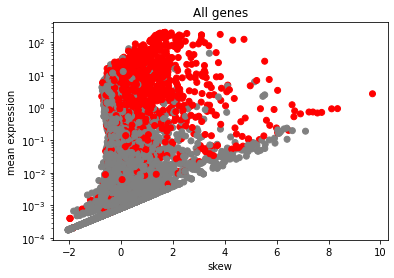

AE4
93.44262295081967 % of the outliers are memory genes


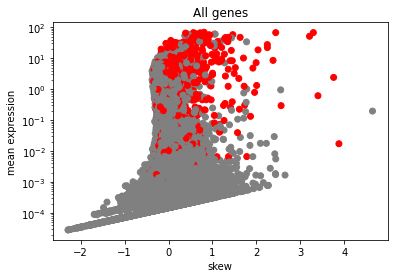

AE7
75.0 % of the outliers are memory genes


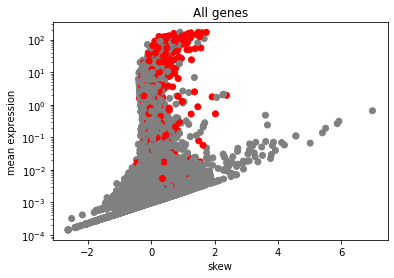

BIDDY_D0
85.71428571428571 % of the outliers are memory genes


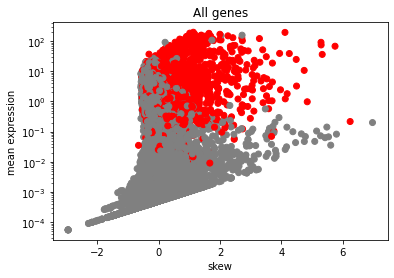

BIDDY_D0_2
84.21052631578948 % of the outliers are memory genes


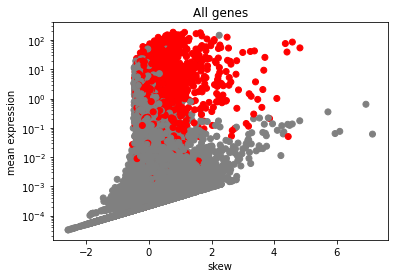

BIDDY_D6
100.0 % of the outliers are memory genes


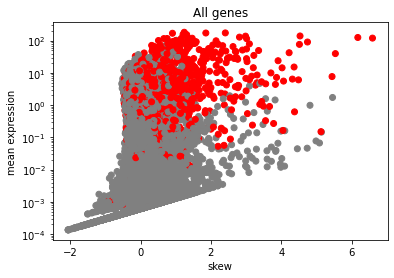

BIDDY_D6_2
66.66666666666667 % of the outliers are memory genes


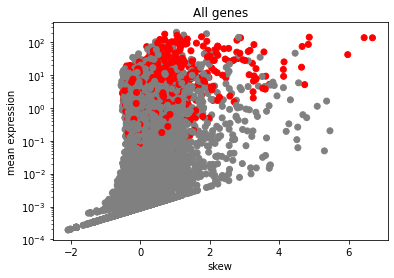

BIDDY_D15
90.0 % of the outliers are memory genes


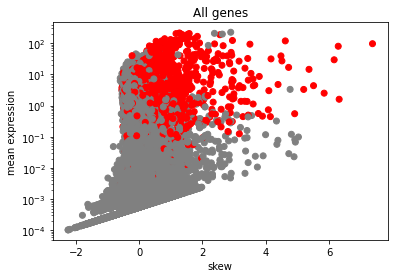

BIDDY_D15_2
71.42857142857143 % of the outliers are memory genes


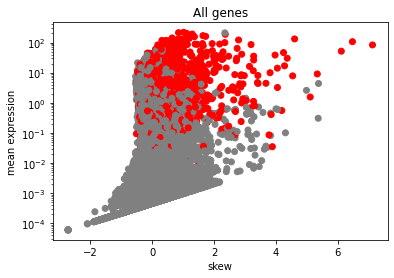

LK_D2_exp1_library_d2_1
85.71428571428571 % of the outliers are memory genes


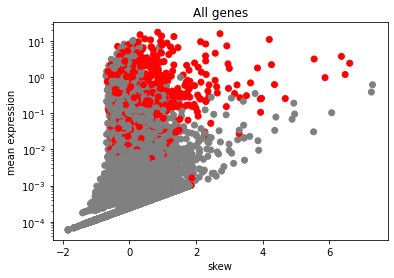

LK_D2_exp1_library_d2_2
100.0 % of the outliers are memory genes


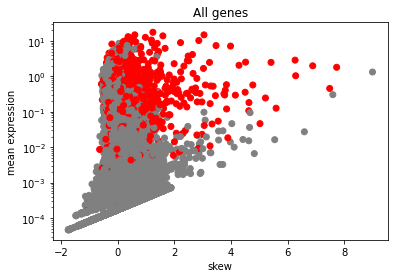

LK_D2_exp1_library_d2_3
83.33333333333333 % of the outliers are memory genes


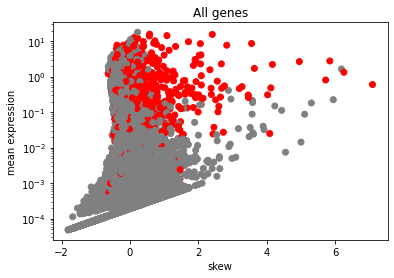

LK_LSK_D2_exp3_library_d2_1
60.0 % of the outliers are memory genes


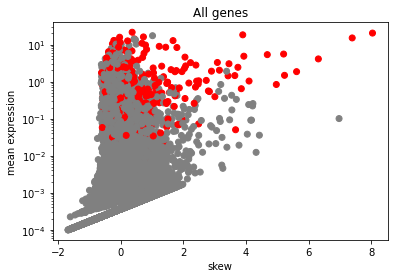

LK_LSK_D2_exp3_library_d2_2
100.0 % of the outliers are memory genes


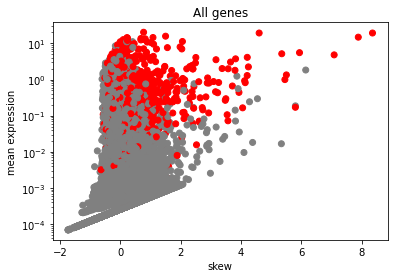

LK_LSK_D2_exp3_library_d2_3
100.0 % of the outliers are memory genes


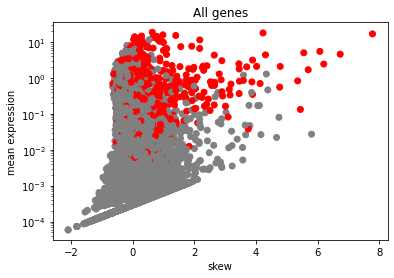

LK_LSK_D2_exp3_library_d2_4
100.0 % of the outliers are memory genes


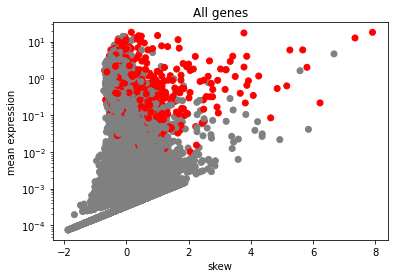

LK_LSK_D2_exp3_library_d2_5
83.33333333333333 % of the outliers are memory genes


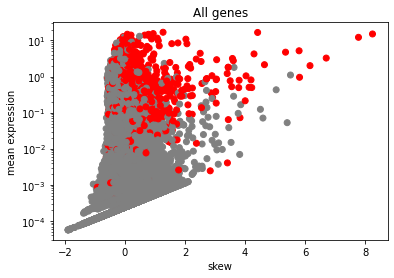

LSK_D2_exp1_library_LSK_d2_1
62.5 % of the outliers are memory genes


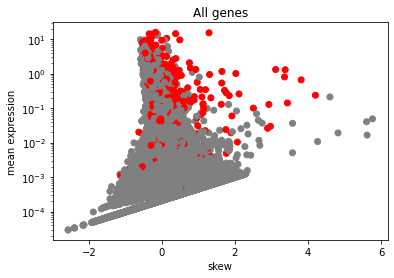

LSK_D2_exp1_library_LSK_d2_2
100.0 % of the outliers are memory genes


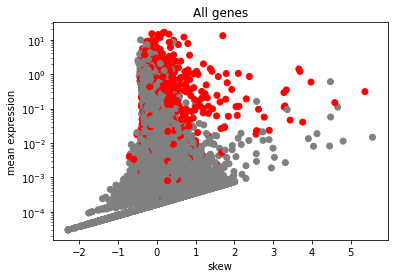

LSK_D2_exp1_library_LSK_d2_3
100.0 % of the outliers are memory genes


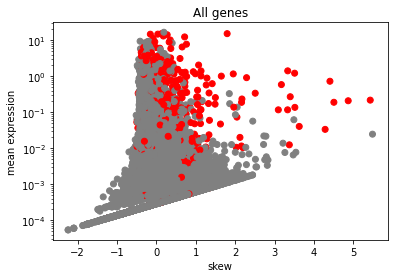

LSK_D2_exp2_library_d2A_1
100.0 % of the outliers are memory genes


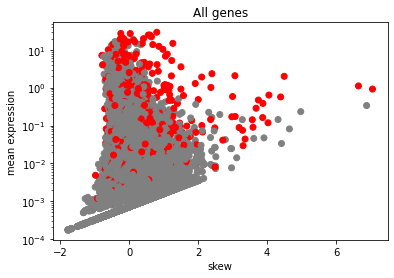

LSK_D2_exp2_library_d2A_2
83.33333333333333 % of the outliers are memory genes


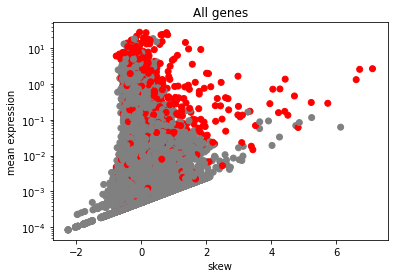

LSK_D2_exp2_library_d2A_3
100.0 % of the outliers are memory genes


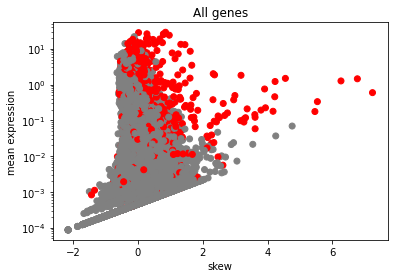

LSK_D2_exp2_library_d2A_4
100.0 % of the outliers are memory genes


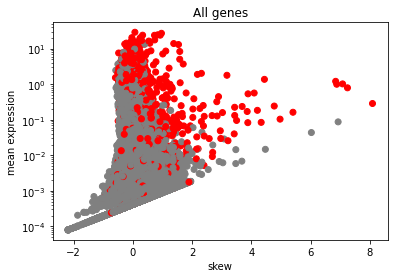

LSK_D2_exp2_library_d2A_5
100.0 % of the outliers are memory genes


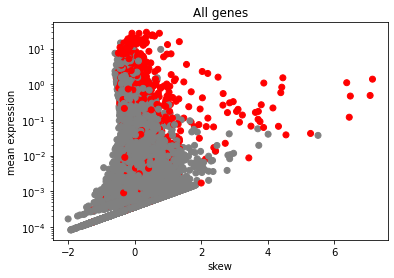

LSK_D2_exp2_library_d2B_1
100.0 % of the outliers are memory genes


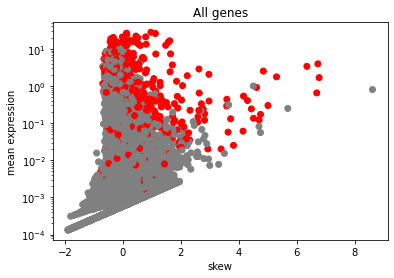

LSK_D2_exp2_library_d2B_2
85.71428571428571 % of the outliers are memory genes


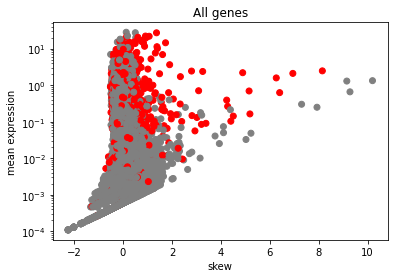

LSK_D2_exp2_library_d2B_3
100.0 % of the outliers are memory genes


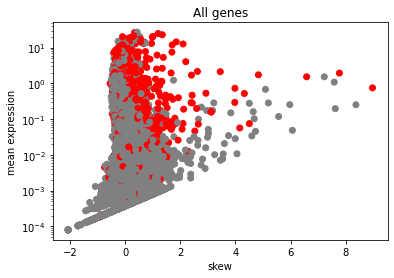

LSK_D2_exp2_library_d2B_4
100.0 % of the outliers are memory genes


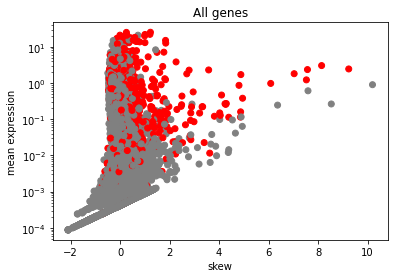

LSK_D2_exp2_library_d2B_5
100.0 % of the outliers are memory genes


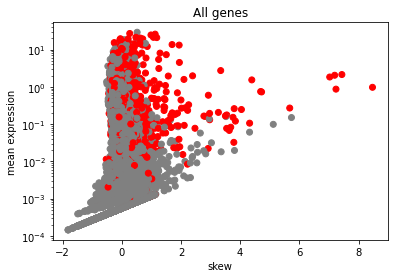

In [5]:
for i,charac in enumerate(charac_matrix):
    print(names[i])
    visualize_charac(charac)

92.3076923076923 % of the outliers are memory genes


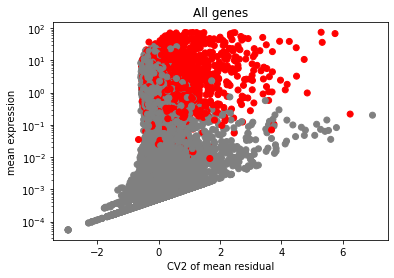

In [4]:
visualize_charac(charac_matrix[3])

# Fuse charac data 

In [12]:
#Remove AE7, also keep BIDDYD15_2 for validation
val = [0,8]
data_to_fuse = [1,3,4,5,6,7] 

outliers = []
for i in range(0,len(charac_matrix)):
    #Normalize skew_residuals, same for mean_expression after removing outliers
    charac_matrix[i], outlier_temp = remove_extreme_values(charac_matrix[i], k=200)
    outliers.append(outlier_temp)
    charac_matrix[i]['CV2ofmeans_residuals'], charac_matrix[i]['mean_expression'] = normalize(charac_matrix[i]['CV2ofmeans_residuals']), normalize(charac_matrix[i]['mean_expression'])
    charac_matrix[i]['length'], charac_matrix[i]['GC'] = normalize(charac_matrix[i]['length']), normalize(charac_matrix[i]['GC'])

val_charac =  []
for i in val:
    val_charac.append(charac_matrix[i])

fused_charac = []
names_fused = []
for i in data_to_fuse:
    fused_charac.append(charac_matrix[i])
    names_fused.append(names[i])
    
fused = pd.concat(fused_charac)

In [13]:
fused

,CV2ofmeans_residuals,mean_expression,memory_gene,length,GC,Pou5f1,Myc,Nanog,Sox2,Dnmt3a,Dnmt1,H3K27me3,H3K4me3,H3K27ac,H3K9me3,H2Aub1,Cbx5,Ctnnb1,Srebf1
ENSMUSG00000000001,0.299603,1.769013e-02,False,0.025643,0.314837,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
ENSMUSG00000000028,0.305114,7.184028e-03,False,0.016551,0.404959,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
ENSMUSG00000000031,0.390226,6.889145e-06,False,0.017713,0.593861,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSMUSG00000000037,0.307224,4.967388e-04,True,0.009352,0.263282,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
ENSMUSG00000000056,0.308919,1.974962e-03,False,0.034849,0.419323,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000118449,0.246661,1.327431e-04,False,0.025439,0.400970,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSMUSG00000118454,0.098931,4.714104e-07,False,0.014966,0.452647,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
ENSMUSG00000118506,0.250560,5.798824e-04,False,0.004249,0.396963,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
ENSMUSG00000118537,0.204447,5.785728e-04,False,0.012244,0.280321,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0


# Neural Network (NN)

In [ ]:
def train_model(train_dl, test_dl, model, criterion, optimizer, plot=False):
    losses, losses_test = [], []
    for epoch in range(100):
        running_loss = 0.0
        for i, (inputs, targets) in enumerate(train_dl):
            #Convert double to float
            inputs, targets = inputs.to(torch.float32),  targets.to(torch.float32)

            optimizer.zero_grad()
            yhat = model(inputs)
            loss = criterion(yhat, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            
        epoch_loss = running_loss / len(train_dl)
        losses.append(epoch_loss)
        
        with torch.no_grad():
            running_loss_test = 0.0
            for i, (inputs, targets) in enumerate(test_dl):
                #Convert double to float
                inputs, targets = inputs.to(torch.float32),  targets.to(torch.float32)

                # evaluate the model on the test set
                yhat = torch.sigmoid(model(inputs))
                loss = criterion(yhat, targets)

                running_loss_test += loss.item() * inputs.size(0)

            epoch_loss = running_loss_test / len(test_dl)
            losses_test.append(epoch_loss)

        
    if plot:
        plt.plot(range(1,101), losses)
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.title("Traning loss at each epoch")
        plt.show()
        
        plt.plot(range(1,101), losses_test)
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.title("Testing loss at each epoch")
        plt.show()

In [6]:
def obj(trial, fused):
    #Set hyperparamters to tune
    params = {
              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 0.01),
              'weight_decay' : trial.suggest_loguniform('weight_decay', 1e-5, 0.1),
              'n1': trial.suggest_int("n1", 4, 50),
              'n2': trial.suggest_int("n2", 4, 50),
              'n3': trial.suggest_int("n3", 4, 50),
              #'n4': trial.suggest_int("n4", 4, 50),
              #'batch_size': trial.suggest_int("batch_size", 5, 8), #2^i
              'nb_features' : trial.suggest_int("nb_features", 2, 18)
              }
    #Load data
    X = fused.drop(columns=['memory_gene'])
    y = fused['memory_gene']*1
    
    #Get the N top features according to mutual information
    selector = SelectKBest(mutual_info_classif, k=params['nb_features'])
    X_redu = selector.fit_transform(X, y)
    cols = selector.get_support(indices=True)
    FS = X.iloc[:,cols].columns.tolist(); FS.append('memory_gene')

    train_dl, test_dl = load_data(fused[FS],params)

    model = NN_4lRBN(len(FS)-1, params)

    #Optmization criterion and optimizer
    num_positives= np.sum(y); num_negatives = len(y) - num_positives
    pos_weight  = torch.as_tensor(num_negatives / num_positives, dtype=torch.float)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])

    #Train and evaluate the NN
    train_model(train_dl, test_dl, model, criterion, optimizer, True)
    acc = evaluate_model(test_dl,model)
    
    return acc

class Objective(object):
    def __init__(self, fused):
        self.fused = fused

    def __call__(self, trial):
        
        acc = obj(trial, self.fused)
        
        return acc

In [2]:
fused = load_charac()
objective = Objective(fused)

In [3]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1)

[I 2022-06-01 10:22:38,634] A new study created in memory with name: no-name-50762971-27c4-4b91-a0b6-1c14b8f94188


tensor(5.4522)


KeyboardInterrupt: 

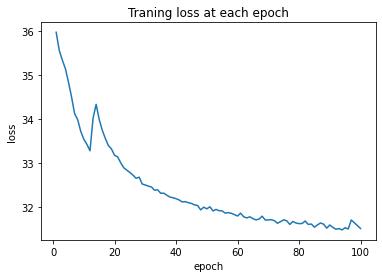

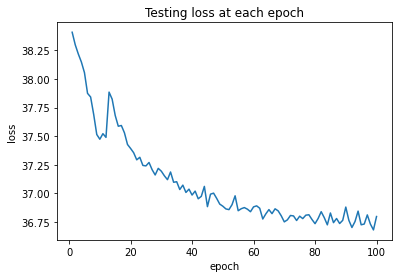

C:\Users\alexi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\alexi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\alexi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\alexi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\alexi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


0.7056115035424887
0.690467789096736


In [7]:
#Load data
X = fused.drop(columns=['memory_gene'])
y = fused['memory_gene']*1
    
#Get the N top features according to mutual information
selector = SelectKBest(mutual_info_classif, k=15)
X_redu = selector.fit_transform(X, y)
cols = selector.get_support(indices=True)
FS = X.iloc[:,cols].columns.tolist();FS.append('CV2ofmeans_residuals'); FS.append('memory_gene'); FS = np.unique(FS)

params = {
            'learning_rate': 1e-4,
            'weight_decay' : 1e-6,
            'n1': 29,
            'n2': 21,
            'n3': 23,
            'nb_features' : 15
        }

train_dl, test_dl = load_data(fused[FS],params)

model = NN_4lRBN(len(FS)-1, params)

#Optmization criterion and optimizer
num_positives= np.sum(y); num_negatives = len(y) - num_positives
pos_weight  = torch.as_tensor(num_negatives / num_positives, dtype=torch.float)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = SGD(model.parameters(), lr=params['learning_rate'], momentum=0.9, weight_decay=params['weight_decay'])

#Train and evaluate the NN
train_model(train_dl, test_dl, model, criterion, optimizer)
acc = evaluate_model(test_dl,model)

print(acc)

In [27]:
#Load data
fused, charac_matrix, norm_matrix, families_matrix, names_val, names_fused, data_to_fuse, val, outliers = load_all_data()

#Train model
params = {  'learning_rate': 1e-4,
            'weight_decay' : 1e-6,
            'n1': 29,
            'n2': 21,
            'n3': 23,
            'nb_features' : 15}

model = train_best_model(fused, params)

#Get the N top features according to mutual information
X, y = fused.drop(columns=['memory_gene']), fused['memory_gene']
FS = FS(X,y,params)

In [28]:
#Evaluate clustering
scores = []
for i in data_to_fuse:
    X = charac_matrix[i][FS]
    y = np.expand_dims(charac_matrix[i]['memory_gene'], axis=1)
    dataset = Dataset(np.array(X), y)
    data = DataLoader(dataset, batch_size = 200000, shuffle=False)
    
    #compute accuracy and predict
    acc = evaluate_model(data,model)
    yhat = predict(np.array(X),model)
    
    #Compute enrichment of gene set (percentage of memory genes recovered + number of non-memory genes in set)
    recovery, false_pos = compute_enrichment(charac_matrix[i], y, yhat)
    score = [acc, recovery, false_pos]
    
    score.extend(predict_evaluate_NN(charac_matrix[i].index, yhat, norm_matrix[i], families_matrix[i], mult_pred=True, outliers = outliers[i]))
    scores.append(score)

#Evaluate clustering on validation set 
for i in val:
    X = charac_matrix[i][FS]
    y = np.expand_dims(charac_matrix[i]['memory_gene'], axis=1)
    dataset = Dataset(np.array(X), y)
    data = DataLoader(dataset, batch_size = 200000, shuffle=False)
    
    #compute accuracy and predict
    acc = evaluate_model(data,model)
    yhat = predict(np.array(X),model)
    
    #Compute enrichment of gene set (percentage of memory genes recovered + number of non-memory genes in set)
    recovery, false_pos = compute_enrichment(charac_matrix[i], y, yhat)
    score = [acc, recovery, false_pos]
    
    score.extend(predict_evaluate_NN(charac_matrix[i].index, yhat, norm_matrix[i], families_matrix[i], mult_pred=True, outliers = outliers[i]))
    scores.append(score)
    
scores_df = pd.DataFrame(scores, index = names_fused + names_val, columns= ['accuracy', 'recovery memory gene', 'FP', 'precision', 'recovery', 'ensembling precision', 'ensembling recovery'])
scores_df.to_csv('../data/binaryClass_scores/bestNN.csv', index=True)

[0.6423082293150149, 0.5924462011418533, 5858.0, 0.12582159624413145, 0.912332838038633, 0.27611940298507465, 0.4234769687964339]
[0.6835987926897018, 0.6330578512396694, 4220.0, 0.8421052631578947, 0.7037037037037037, 0.9444444444444444, 0.6666666666666666]
[0.6704723935616781, 0.6191673651858061, 4865.0, 0.6511627906976745, 0.6056338028169014, 0.75, 0.5070422535211268]
[0.6859323078485833, 0.6555793991416309, 4723.0, 0.8095238095238095, 0.6885245901639344, 0.85, 0.6557377049180327]
[0.6813242454131149, 0.6622706422018348, 5075.0, 0.8, 0.5555555555555556, 0.8, 0.5555555555555556]
[0.6812442586229724, 0.6454896454896455, 4515.0, 1.0, 0.7894736842105263, 1.0, 0.7894736842105263]
